In [127]:
%pylab inline 

import json
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import PorterStemmer
import progressbar

import time

Populating the interactive namespace from numpy and matplotlib


/Users/shraws/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
REVIEWS = 'reviews'

In [44]:

category_map = {
   # "Amazon_Instant_Video" : 0,
   # "Apps_for_Android" : 1,
   # "Automotive" : 2,
   # "Baby" : 3,
   # "Beauty" : 4,
   # "Books" : 5,
#     "CDs_and_Vinyl" : 6,
#     "Cell_Phones_and_Accessories" : 7,
#     "Clothing_Shoes_and_Jewelry" : 8,
#     "Digital_Music" : 9,
#    "Electronics" : 10
#     "Grocery_and_Gourmet_Food" : 11,
#     "Health_and_Personal_Care" : 12,
#     "Home_and_Kitchen" : 13,
#     "Kindle_Store" : 14,
#     "Movies_and_TV" : 15,
#     "Musical_Instruments" : 16,
     "Office_Products" : 17
#     "Patio_Lawn_and_Garden" : 18,
#     "Pet_Supplies" : 19,
#     "Sports_and_Outdoors" : 20,
#     "Tools_and_Home_Improvement" : 21,
#     "Toys_and_Games" : 22,
#     "Video_Games" : 23
}

col_names = ["reviewer_id", "asin", "summary","review_text", "overall", "category", "total_votes","upvotes","score",
             "good", "bad"]

In [45]:
def read_dataset():
    data =[]
    for category in category_map:
        fn = "data/" + REVIEWS+ "_" + category + "_"+"5" + ".json"
        print("Reading category", category)
        with open(fn) as f:
            for line in f:
                d = json.loads(line)
                pf, tf = d["helpful"]
                if tf >1 and len(d["reviewText"].split())  >10:
                    score = int(pf) / int(tf)
                    row = [d["reviewerID"], 
                           d["asin"], 
                           d["summary"],
                           d["reviewText"],
                           d["overall"],
                           category_map[category],
                           int(tf),
                           int(pf),
                           (score),
                           int(score >= 0.80),
                           int(score <= 0.20)]
                    data.append(row)
                    
    return pd.DataFrame(data, columns=col_names)


#df = df.sample(frac=1).reset_index(drop=True) # Randomize entry order


In [46]:
#Aggregating the review data across all categories
df = read_dataset()
df.head()

Reading category Office_Products


,reviewer_id,asin,summary,review_text,overall,category,total_votes,upvotes,score,good,bad
0,A32T2H8150OJLU,B00000JBLH,"A solid performer, and long time friend","I bought my first HP12C in about 1984 or so, a...",5.0,17,4,3,0.750000,0,0
1,A3MAFS04ZABRGO,B00000JBLH,"Price of GOLD is up, so don't bury the golden ...",WHY THIS BELATED REVIEW? I feel very obliged t...,5.0,17,9,7,0.777778,0,0
2,A1F1A0QQP2XVH5,B00000JBLH,"Good functionality, but not durable like old HPs",I have an HP 48GX that has been kicking for mo...,2.0,17,3,3,1.000000,1,0
3,A49R5DBXXQDE5,B00000JBLH,One of the last of an almost extinct species,I've started doing more finance stuff recently...,5.0,17,8,7,0.875000,1,0
4,A2JFOHC9W629IE,B00000JBLH,Every MBA student and grad should get one,"While I don't have an MBA, it's hard to believ...",5.0,17,12,10,0.833333,1,0


In [47]:
len(df)

12000

In [48]:
df['review_length'] = [len(x.split()) for x in df['review_text']]

In [49]:
df.head()

,reviewer_id,asin,summary,review_text,overall,category,total_votes,upvotes,score,good,bad,review_length
0,A32T2H8150OJLU,B00000JBLH,"A solid performer, and long time friend","I bought my first HP12C in about 1984 or so, a...",5.0,17,4,3,0.750000,0,0,186
1,A3MAFS04ZABRGO,B00000JBLH,"Price of GOLD is up, so don't bury the golden ...",WHY THIS BELATED REVIEW? I feel very obliged t...,5.0,17,9,7,0.777778,0,0,911
2,A1F1A0QQP2XVH5,B00000JBLH,"Good functionality, but not durable like old HPs",I have an HP 48GX that has been kicking for mo...,2.0,17,3,3,1.000000,1,0,96
3,A49R5DBXXQDE5,B00000JBLH,One of the last of an almost extinct species,I've started doing more finance stuff recently...,5.0,17,8,7,0.875000,1,0,603
4,A2JFOHC9W629IE,B00000JBLH,Every MBA student and grad should get one,"While I don't have an MBA, it's hard to believ...",5.0,17,12,10,0.833333,1,0,180


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22305be0>]], dtype=object)

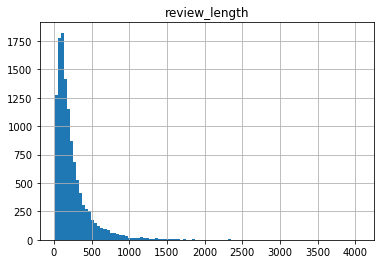

In [50]:
df.hist(column='review_length',bins =100)

In [51]:
sorted(df['review_length'],reverse=True)[:10]

[4050, 3854, 3624, 3448, 3164, 3134, 2877, 2804, 2692, 2548]

In [52]:
np.median(df['review_length'])

164.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22ca6198>]], dtype=object)

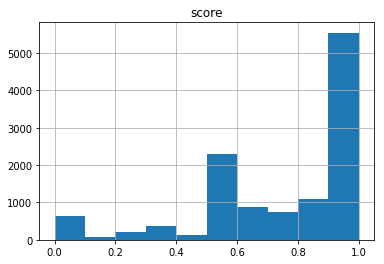

In [53]:
df.hist(column='score')

In [55]:
#score_plus = df[df['score']>0.5]
#score_minus = df[df['score']<=0.5]

In [56]:
#df = df[df['total_votes']>5]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22dc4b70>]], dtype=object)

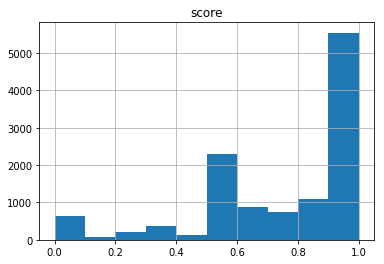

In [57]:
df.hist(column='score')

In [58]:
len(df)

12000

In [60]:
np.min(df['score'])

0.0

In [62]:
score_mean = np.mean(df['score'])
print(score_mean)

0.7473203155645903


In [63]:
score_median = np.median(df['score'])
print(score_median)

0.857142857143


In [64]:
# df_good = df.loc[df['good'] == 1]
# df_bad = df.loc[df['bad'] == 1]
# df_neutral =  df.loc[(df['good'] == 0) & (df['bad'] == 0)]

In [66]:
# print ("Number of entries:", len(df))
# print ("Good count:", len(df_good))
# print( "Bad count:", len(df_bad))
# print( "Neutral count:", len(df_neutral))

# del df_bad,df_good,df_neutral

In [80]:
df_good = df[df['score']>=score_median]
df_bad = df[df['score']<score_median]

len_bad = len(df_bad)
len_good = len(df_good)

In [81]:
print("Not Helpful reviews",len_bad)
print("Helpful reviews", len_good)
print("Baseline accuracy",len_good/len(df))

Not Helpful reviews 5967
Helpful reviews 6033
Baseline accuracy 0.50275


In [82]:

def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(keywords)
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic

In [83]:

def create_bag_of_words(corpus,
                       NGRAM_RANGE=(0,1),
                       stop_words = None,
                       stem = False,
                       MIN_DF = 0.02,
                       MAX_DF = 0.8,
                       USE_IDF=False):
    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tupule
        range of N-gram default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
     
    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

In [84]:
def get_word_counts(bag_of_words, feature_names):
    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """
    np_bag_of_words = bag_of_words.toarray()
    word_count = np.sum(np_bag_of_words,axis=0)
    np_word_count = np.asarray(word_count).ravel()
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    orddict_word_counts = OrderedDict( 
                                    sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [85]:
corpus = df["review_text"]

In [91]:
#Stop word list
eng_stopwords =  stopwords.words('english')

#get rid of the punctuations and set all characters to lowercase
RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters
stemmer = PorterStemmer()

In [92]:
#Retrieve words and lowercase them
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )

NameError: name 'processed_bag_of_words' is not defined

NameError: name 'dict_processed_word_counts' is not defined

In [94]:
#Get bag of words with stemming, removing stop words and TFIDF vector
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=eng_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2),
                                                                 USE_IDF = True)


In [95]:
#Get word counts
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)

In [97]:
dict_processed_word_counts

OrderedDict([('use', 20176.02764670282),
             ('printer', 19592.250189196962),
             ('print', 18409.795381346888),
             ('wa', 16807.583008076246),
             ('one', 16387.538592702556),
             ('paper', 14780.491292111594),
             ('veri', 13812.973681595393),
             ('like', 13789.446386006301),
             ('work', 13484.119637998592),
             ('ink', 12826.30240780504),
             ('get', 12560.534884023036),
             ('need', 12444.042537174681),
             ('color', 12333.223066667513),
             ('ha', 12176.3035471617),
             ('time', 11842.107550721972),
             ('would', 11819.499681296193),
             ('good', 11522.870902680499),
             ('well', 11381.749883885406),
             ('also', 11294.119172790895),
             ('set', 11115.623960705982),
             ('make', 11065.562094644505),
             ('qualiti', 10944.795178886348),
             ('onli', 10865.376765603731),
             (

In [98]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 7,
                                                      N_TOP_WORDS= 7)

/ 0 Elapsed Time: 0:00:00                                                      /Users/shraws/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| 1 Elapsed Time: 0:01:09                                                      


0 label, tape, binder, use, product, box, paper
1 time, one, wa, lamin, year, get, thing
2 pen, write, color, ink, blue, like, black
3 printer, print, thi printer, photo, wireless, ink, epson
4 desk, pencil, pad, sharpen, heavi, chair, stapl
5 phone, button, call, number, batteri, featur, devic
6 scan, softwar, scanner, instal, ink cartridg, cartridg, window


In [99]:
processed_bag_of_words.shape

(12000, 1028)

In [201]:
df.loc[1,"good"]

0

In [109]:
y= []
for score in df['score']:
    if score >= score_median:
        y.append(1)
    else:
        y.append(0)
# for i in range(len(df)):
#     if df.loc[i,"good"]==1:
#         y.append(1)
#     elif df.loc[i,"bad"] ==1:
#         y.append(-1)
#     else:
#         y.append(0)

In [75]:
#Supervised Classification

In [112]:
X_train,X_test,y_train,y_test = train_test_split(processed_bag_of_words,y,test_size=0.2, random_state=42)

In [115]:
print("Length of training data",len(y_train))
print("Length of test data", len(y_test))

Length of training data 9600
Length of test data 2400


In [118]:
baseline_accuracy = sum(y_test)/len(y_test)
print("baseline accuracy for test data", baseline_accuracy)

baseline accuracy for test data 0.502083333333


In [102]:
#parameters for vectorizer 
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) #Range for pharases of words
MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

In [103]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( X_train["review_text"] ) #using all the data on for generating features!! Bad!
test_bag_of_words = vectorizer.transform( X_test["review_text"] )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 7.64s


In [164]:
clf = LogisticRegression(penalty='l1',C=0.03)
mdl = clf.fit(X_train, y_train) #train the classifer to get the model
y_score = mdl.predict_proba(X_test )
y_pred = mdl.predict(X_test)

In [165]:
accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)

0.62041666666666662

0.58833333333333337

In [166]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

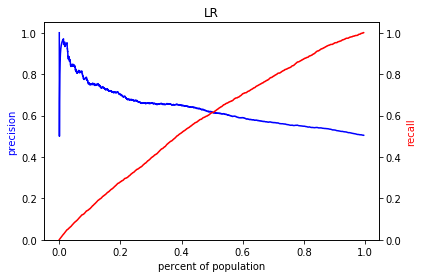

In [167]:
plot_precision_recall_n(y_test, y_score[:,1], 'LR')

In [168]:

def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.659074


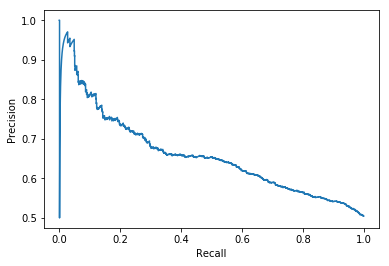

In [169]:
plot_precision_recall(y_test,y_score)


In [122]:
np.sum(y_test)/len(y_test)

0.63089005235602091

In [127]:
# Class for defining LabeledSentence iterator object for the documents
class LabeledLineSentence(object):
        def __init__(self, doc_list, labels_list):
            self.labels_list = labels_list
            self.doc_list = doc_list
        def __iter__(self):
            for idx, doc in enumerate(self.doc_list):
                yield models.doc2vec.LabeledSentence(doc,[self.labels_list[idx]])

In [128]:
def pre_process(docs): 
    processed_corpus=[]
    for i in range(len(docs)):
        doc = docs[i].split()
        processed_corpus.append(doc)
    return processed_corpus

In [129]:
#This function converts the corpus to a doc2vec vector and return the corresponding vectors
def get_doc2vec(train_corpus,test_corpus):
    
    #Creating unique labels for each jon description
    train_doc_labels = np.array(['Train{}'.format(i) for i in range(len(train_corpus))])
    test_doc_labels = np.array(['Test{}'.format(i) for i in range(len(test_corpus))])

    it_train = LabeledLineSentence(train_corpus, train_doc_labels)
    it_test =  LabeledLineSentence(test_corpus, test_doc_labels)
    
    
    model_train = models.Doc2Vec( min_count=1, workers=11,alpha=0.025, min_alpha=0.025) 
    model_test  = models.Doc2Vec( min_count=1, workers=11,alpha=0.025, min_alpha=0.025) 
    
    #Building vocabulary for both training and testing Doc2vec models
    model_train.build_vocab(it_train)
    model_test.build_vocab(it_test)
    
    #Training the train corpus
    for epoch in range(10):
        model_train.train(it_train,total_examples=model_train.corpus_count,epochs=model_train.iter)
        model_train.alpha -= 0.002
        model_train.min_alpha = model_train.alpha
        
    #Training the test corpus
    for epoch in range(10):
        model_test.train(it_test,total_examples=model_test.corpus_count,epochs=model_test.iter)
        model_test.alpha -= 0.002
        model_test.min_alpha = model_test.alpha
    
    print("Finished Training!")
    model_train.save("train_model.doc2vec")
    d2v_train_model = models.doc2vec.Doc2Vec.load('train_model.doc2vec')

    model_test.save("test_model.doc2vec")
    d2v_test_model = models.doc2vec.Doc2Vec.load('test_model.doc2vec')
    
    train_vecs = np.array(model_train.docvecs)
    test_vecs = np.array(model_test.docvecs)
    
    return train_vecs,test_vecs